In [57]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [58]:
# scipy

# testes paramétricos.
from scipy.stats import ttest_rel # pareado.
from scipy.stats import ttest_ind # não-pareado.

# testes não-paramétricos.
from scipy.stats import wilcoxon # pareado.
from scipy.stats import mannwhitneyu # não-pareado.

In [59]:
# criando um dataset sintético.
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=50, 
                           n_informative=10, n_redundant=5, 
                           n_repeated=5, n_classes=3, random_state=20)

In [60]:
# importando classificadores.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [61]:
lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=3)

In [62]:
# implementando k-fold: dividir o kfold em k dobras,
# sendo que 1 parte fica para teste e (k-1) para treino,
# esse processo é repetido k vezes.
# estratificação: visa garantir que o percentual de cada
# classe em cada fold, é o mesmo que o percentual no dataset inteiro. 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=911)

In [63]:
# criando tabela de resultados.
resultados = pd.DataFrame(columns=['lr', 'dt', 'knn'])

In [64]:
# for (treino e teste) e, dentro do for, eu crio e testo.
# TODOS os classificadores, então é um cenário PAREADO.

# Vários laços de repetição, um por classificador, eu
# tenho um cenário NÃO-PAREADO.
# Existe uma exceção: se em cada laço de repetição nos mantivermos
# o random state do processo de validação, o cenário continua pareado.

In [65]:
# Um laço de repetição que treina todos os classificadores.
# Cenário pareado:
for train_index, test_index in skf.split(X, y):
    # Obtendo conjuntos de treino e teste:
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    # treino dos classificadores:
    lr.fit(X_train, y_train)
    dt.fit(X_train, y_train)
    knn.fit(X_train, y_train)

    # teste dos classificadores:
    acc_lr = accuracy_score(y_test, lr.predict(X_test))
    acc_dt = accuracy_score(y_test, dt.predict(X_test))
    acc_knn = accuracy_score(y_test, knn.predict(X_test))

    # guardando os resultados:
    linha = {'lr':acc_lr, 'dt':acc_dt, 'knn':acc_knn}
    resultados = resultados.append(linha, ignore_index=True)

In [66]:
print(resultados)

      lr     dt    knn
0  0.613  0.727  0.854
1  0.623  0.715  0.881
2  0.646  0.763  0.859
3  0.598  0.746  0.868
4  0.634  0.763  0.870
5  0.636  0.726  0.858
6  0.624  0.744  0.848
7  0.612  0.732  0.856
8  0.635  0.733  0.893
9  0.623  0.725  0.885


In [67]:
# para determinar se devo usar um teste paramétrico ou não,
# preciso garantir que todas as colunas tenham comportamento normal (gaussiano)
# OU que meu experimento foi executado ao menos 30 vezes.

In [68]:
# Como conclusão, precisamos usar um teste pareado e não-paramétrico.
# Wilcoxon:
# Alerta: wilcoxon, mann-whitey, e testes t só permitem avaliar
# duas alternativas(classificadores).
stat, p = wilcoxon(resultados['dt'], resultados['knn'])
if p < 0.05: # 95% de confiança.
    print('Há diferença significativa.')
else:
    print('Não há diferença significativa.')

Há diferença significativa.


In [69]:
stat, p = wilcoxon(resultados['knn'], resultados['lr'])
if p < 0.05: # 95% de confiança.
    print('Há diferença significativa.')
else:
    print('Não há diferença significativa.')

Há diferença significativa.


In [70]:
# neste ponto, eu poderia acabar assumindo que DT > LR,
# mas isso está, estatisticamente, incorreto!
# a solução seria usar testes para múltiplas alternativas.

In [71]:
# testes de múltiplas alternativas(múltiplas comparações).

# 2 etapas: Friedman(determina se há ou não diferença).
#           Nmenyi: onde esta a diferença.

In [72]:
from scipy.stats import friedmanchisquare
stat, p = friedmanchisquare(resultados['lr'], resultados['dt'], resultados['knn'])
if p < 0.05: # 95% de confiança.
    print('Há diferença significativa.')
else:
    print('Não há diferença significativa.')

Há diferença significativa.


In [73]:
# criar tabela de ranking:
from scipy.stats import rankdata
ranking = (resultados * -1).apply(lambda row: rankdata([row['lr'], row['dt'], row['knn']]), axis=1)
#print(resultados)
#print(ranking)

In [74]:
!pip install orange3

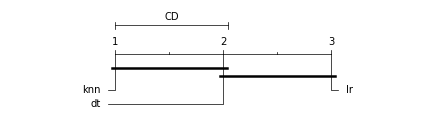

In [75]:
import Orange
nomes = resultados.columns.values
avgrank = ranking.mean() # média por coluna(classificador).
cd = Orange.evaluation.compute_CD(avgrank, len(ranking), alpha="0.05")
Orange.evaluation.graph_ranks(avgrank, nomes, cd=cd, width=6, textspace=1.5)
plt.show()

In [76]:
# Testes bayesianos:
!pip install baycomp

In [77]:
from baycomp import two_on_multiple # dois classificadores em múltiplas bases.
from itertools import combinations # auxiliar para todos os pares possíveis de calssificadores.
# dt x lr, dt x knn, knn x lr, ...

In [78]:
# Estruturas auxiliares do teste bayesiano e uma lista de índices.
n_classif = len(resultados.columns)
matrix_bayes = np.zeros((n_classif, n_classif), dtype=float)
indices = np.arange(n_classif)

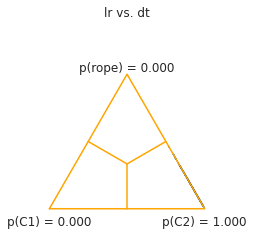

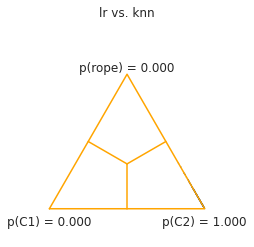

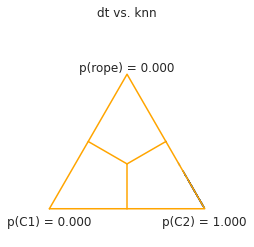

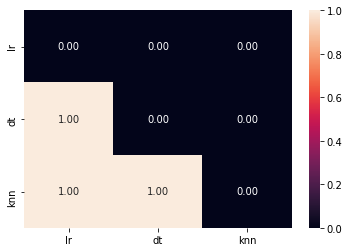

In [79]:
# criar as combinações possíveis entre os classificadores.
# e para cada combinação, aplicar o teste bayesiano.
for i in combinations(indices, 2):
    # aplicar o teste bayesiano.
    clf1, clf2 = resultados.columns[i[0]], resultados.columns[i[1]]
    (prob_1, rope, prob_2), figura = two_on_multiple(resultados[clf1], 
                                                     resultados[clf2],
                                           rope=0.05, nsamples=10000, plot=True)
    
    # armazenar os resultados:
    matrix_bayes[i[0]][i[1]] = prob_1
    matrix_bayes[i[1]][i[0]] = prob_2

    # aprensentar os resultados da comparação:
    plt.title(f'{clf1} vs. {clf2}')
    plt.show()

sns.heatmap(matrix_bayes, annot=True, 
            xticklabels=resultados.columns,
            yticklabels=resultados.columns, fmt='.2f')
plt.show()